In [1]:
import watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.5
IPython 6.4.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.0
matplotlib 2.2.2
statsmodels 0.9.0rc1
sklearn 0.19.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import _pickle as pkl
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import operator
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
import ciso8601
import time
import seaborn as sns
%matplotlib inline

In [4]:
PATH_TO_DATA = r'C:\Users\preductor\Documents\MachineLearning\6_course\Intruder_detection\capstone_user_identification'

In [5]:
PATH_TO_DATA2 = r'F:\Intruder_detection'

## ---------------------------------------------------------------------------------------------

In [6]:
def prepare_train_set(path_to_csv_files, session_length=10):
    # Все пути к файлам в указанной папке
    paths = sorted(glob(path_to_csv_files))
    
    # Создадим словарь с частотами встречаемости сайтов, пока без идентификационного номера
    temp = dict()
    for path in paths:
        table = pd.read_csv(path)
        for site in table.site:
            try:
                inc = temp[site][1] + 1
                temp[site] = (0,inc)
            except(KeyError):
                temp[site] = (0,1)
                
    # Отсортируем
    sorted_temp = sorted(temp.items(), key=operator.itemgetter(1), reverse=True)
    
    # Теперь меньшие индексы присвоим более часто попадающимся сайтам 
    #(приницип наименьшего описания)
    frequency = dict()
    for idx,i in enumerate(sorted_temp):
        frequency[i[0]] = (idx+1, i[1][1])
        
    # Заполним sessions
    
    sess_list = list()
    
    for path in tqdm_notebook(paths):
        user_id = int(path[-8:-4])
        table = pd.read_csv(path)
        table['number'] = table.site.map(lambda x: frequency[x][0])
        temp = list(table.number)

        while len(temp)%session_length!=0:
            temp.append(0)

        pro_temp = np.reshape(np.array(temp), (-1, session_length))

        for row in pro_temp:
            sess_list.append(np.append(np.squeeze(row), user_id))
            
    sessions = pd.DataFrame(sess_list, columns=['site'+str(x) for x in range(1,11)]+['user_id'])
    
            
    return sessions, frequency

## Week_1_Part_2. Работа с разреженным форматом данных

<font color='blue'>Функция для разрежевания</font>

In [7]:
def to_csr(X):
    X_sparse = np.zeros((X.shape[0], X.max()+1), dtype=np.int8)
    
    for idx,row in tqdm_notebook(enumerate(X)):
        for elem in row:
            X_sparse[idx][elem] += 1

    return X_sparse[:,1:]

<font color='blue'>Применим к 150 users</font>

In [8]:
# train_data_150users, site_freq_150users = prepare_train_set(os.path.join(PATH_TO_DATA, 
#                                        '150users/*.csv'))

In [9]:
# train_data_150users = pd.read_csv(os.path.join(PATH_TO_DATA, 
#                                         'train_data_150users.csv'))
# train_data_150users.set_index('session_id', inplace=True)
# train_data_150users.head()

In [10]:
# X_150users, y_150users = train_data_150users.values[:,:-1], train_data_150users.values[:,-1]

In [11]:
# X_sparse_150users = to_csr(X_150users)

<font color='blue'>Применим к 10 users</font>

In [12]:
# train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, 
#                                        '10users/*.csv'))

In [13]:
# train_data_10users.to_csv(os.path.join(PATH_TO_DATA, 
#                                         'train_data_10users.csv'), 
#                          index_label='session_id', float_format='%d')

In [14]:
# X_10users, y_10users = train_data_10users.values[:,:-1], train_data_10users.values[:,-1]
# X_sparse_10users = to_csr(X_10users)

<font color='blue'>Сериализуем данные</font>

In [15]:
# train_data_3users, site_freq_3users = prepare_train_set(os.path.join(PATH_TO_DATA, 
#                                        '3users/*.csv'))

# Week_2
## -------------------------------------------------------------------------------------------

In [16]:
def to_csr(X):
    X_sparse = np.zeros((X.shape[0], X.max()+1), dtype=np.int8)
    
    for idx,row in enumerate(X):
        for elem in row:
            X_sparse[idx][elem] += 1

    return X_sparse[:,1:]

In [17]:
def prepare_sparse_train_set_window(path_to_csv_files, site_freq_path, 
                                                window_size, session_length=10):
    # Все пути к файлам в указанной папке
    paths = sorted(glob(path_to_csv_files))
    
    # Загрузим frequency 
    
    with open(site_freq_path, 'rb') as site_freq_users_pkl:
        frequency = pickle.load(site_freq_users_pkl)
    
    # Заполним sessions
    sess_list = list()
    
    for path in tqdm_notebook(paths):
        user_id = int(path[-8:-4])
        table = pd.read_csv(path)
        table['number'] = table.site.map(lambda x: frequency[x][0])
        numbers = list(table.number)

        for i in range(session_length-1):
            numbers.append(0)
        
        for idx,num in enumerate(numbers):
            if (idx%window_size==0)&(idx<=len(numbers)-session_length):
                sess = numbers[idx:idx+session_length]
                sess.append(user_id)
                sess_list.append(sess)
            
    sessions = pd.DataFrame(sess_list, columns=
                            ['site'+str(x) for x in range(1,session_length+1)]+['user_id'])
    
    X, y = sessions.values[:,:-1], sessions.values[:,-1]
    
    X_sparse = to_csr(X)
    
    
    return X_sparse, y

In [18]:
# X_sparse, users_ID = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, '3users/*.csv'),
#                                 os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'), 3, 5)
# X_sparse

### <font color='red'>Сериализация не прошла</font>

In [19]:
# %%time
# data_lengths = []
# count=1
# for num_users in [10,150]:
#     path_to_csv_files = os.path.join(PATH_TO_DATA, '{}users/*.csv'.format(num_users))
#     site_freq_path = os.path.join(PATH_TO_DATA, 'site_freq_{}users.pkl'.format(num_users))
        
#     for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
#         if window_size <= session_length and (window_size, session_length) != (10, 10):
#             print(count)
#             count += 1
#             X_sparse, y = prepare_sparse_train_set_window(path_to_csv_files, site_freq_path,
#                                                      window_size, session_length)
#             data_lengths.append(X_sparse.shape)
            
            # ----------------------------------------
            
#             with open(os.path.join(PATH_TO_DATA2,
#                 'X_sparse_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size)),
#                       'wb') as X_pkl:
#                 pkl.dump(X_sparse, X_pkl)         
#             with open(os.path.join(PATH_TO_DATA2,
#                 'y_{}users_s{}_w{}.pkl'.format(num_users, session_length, window_size)),
#                       'wb') as y_pkl:
#                 pkl.dump(y, y_pkl)
            

## ----------------------------------------------------------------------------------

<font color='green'>Распределение целевого класса</font>

In [20]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), 
                       index_col='session_id')

In [21]:
train_df['user_id'].value_counts()

128    2796
39     2204
207    1868
127    1712
237    1643
33     1022
50      802
31      760
100     720
241     534
Name: user_id, dtype: int64

<font color='green'>Посчитаем распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов</font>

In [22]:
num_unique_sites = [np.unique(train_df.values[i, :-1]).shape[0] 
                    for i in range(train_df.shape[0])]

In [23]:
num_unique_sites_sum = pd.Series(num_unique_sites).value_counts()

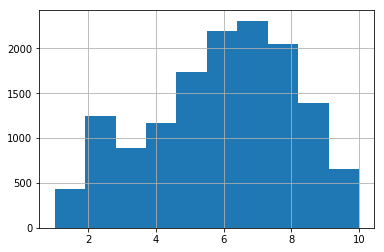

In [24]:
pd.Series(num_unique_sites).hist()

### <font color='green'>Вопрос 2</font>

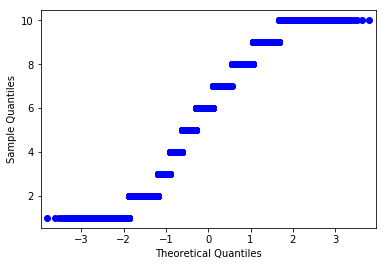

In [25]:
sm.qqplot(pd.Series(num_unique_sites));

In [26]:
from scipy.stats import shapiro

In [27]:
shapiro(pd.Series(num_unique_sites))

(0.9546933174133301, 0.0)

<font color='green'>QQ-plot отклоняется от диагонали довольно сильно, хвосты тяжелые. Критерий Шапиро-Уилка уверенно отвергает нулевую гипотезу о том что данные взяты из нормального распределения. Ответ: нет</font>

### <font color='green'>Вопрос 3</font>

In [28]:
from scipy.stats import binom_test

In [29]:
success = num_unique_sites_sum[num_unique_sites_sum.index!=10].sum()
failure = num_unique_sites_sum[num_unique_sites_sum.index==10].sum()

In [30]:
binom_test(success, success+failure, p=0.95, alternative='greater')

0.02207653769072678

<font color='green'>На уровне значимости 0.022 нулевая гипотеза о том что успешных случаев меньше 95% отвергается</font>

### <font color='green'>Вопрос 4</font>

<font color='green'>Каков 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт (из п. 3)</font>

In [31]:
from statsmodels.stats.proportion import proportion_confint

In [32]:
wilson_interval = proportion_confint(success, success+failure, alpha=0.05, method='wilson')
wilson_interval

(0.9501028841411286, 0.9570527377232229)

In [33]:
print('{} {}'.format(round(wilson_interval[0], 3),
                                   round(wilson_interval[1], 3)))

0.95 0.957


### <font color='green'>Вопрос 5</font>

<font color='green'>Постройте распределение частоты посещения сайтов (сколько раз тот или иной сайт попадается в выборке) для сайтов, которые были посещены как минимум 1000 раз.</font>

In [34]:
import _pickle as pkl

In [35]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as X10_pkl:
    site_freq_10users = pkl.load(X10_pkl)

In [36]:
train_data_10users, site_freq_10users = prepare_train_set(os.path.join(PATH_TO_DATA, 
                                       '10users/*.csv'))

In [37]:
more_1000 = dict()
for key, value in site_freq_10users.items():
    if value[1]>1000:
        more_1000[key] = value

In [38]:
more_1000

{'s.youtube.com': (1, 8300),
 'www.google.fr': (2, 7813),
 'www.google.com': (3, 5441),
 'mail.google.com': (4, 4158),
 'www.facebook.com': (5, 4141),
 'apis.google.com': (6, 3758),
 'r3---sn-gxo5uxg-jqbe.googlevideo.com': (7, 3244),
 'r1---sn-gxo5uxg-jqbe.googlevideo.com': (8, 3094),
 'plus.google.com': (9, 2630),
 'accounts.google.com': (10, 2089),
 'r2---sn-gxo5uxg-jqbe.googlevideo.com': (11, 1939),
 'fr-mg42.mail.yahoo.com': (12, 1868),
 'www.youtube.com': (13, 1804),
 'r4---sn-gxo5uxg-jqbe.googlevideo.com': (14, 1702),
 'clients1.google.com': (15, 1493),
 'download.jboss.org': (16, 1441),
 's-static.ak.facebook.com': (17, 1388),
 'static.ak.facebook.com': (18, 1265),
 'i1.ytimg.com': (19, 1232),
 'twitter.com': (20, 1204),
 'accounts.youtube.com': (21, 1057),
 'platform.twitter.com': (22, 1041),
 'clients6.google.com': (23, 1039),
 'safebrowsing-cache.google.com': (24, 1039),
 'translate.google.fr': (25, 1002)}

In [39]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'), 'rb') as X10_pkl:
    X_sparse_10users = pkl.load(X10_pkl)

In [40]:
def plot_frequency(n):
    temp = pd.Series(X_sparse_10users[:,n-1]).value_counts()
    temp[temp.index!=0].sort_index().plot.bar()

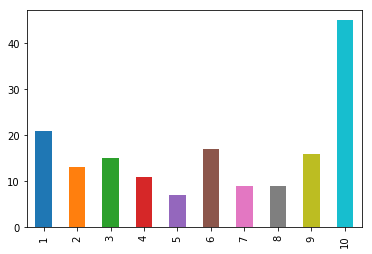

In [41]:
plot_frequency(25)

## -----------------------------------------------------------------------------

<font color='green'>Каков 95% доверительный интервал для средней частоты появления сайта в выборке</font>

In [42]:
X_sparse_10users.shape

(14061, 4913)

In [43]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [44]:
frequencies = []
for value in site_freq_10users.values():
    frequencies.append(value[1])
frequencies = np.asarray(frequencies)

In [45]:
stat = map(np.mean, get_bootstrap_samples(frequencies, 4913))

stat_intervals(list(stat), 0.05)

array([22.51524527, 35.76303684])

# Week_3
## -------------------------------------------------------------------------------------------

In [46]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [47]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names=feature_names,
                                    session_length=10, window_size=10):
    
    # Все пути к файлам в указанной папке
    paths = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    
    # Загрузим frequency 
    with open(site_freq_path, 'rb') as site_freq_users_pkl:
        frequency = pickle.load(site_freq_users_pkl)
        
    # Заполним sessions
    sess_list = list()
    
    for path in tqdm_notebook(paths):
        target = int(path[-8:-4])
        table = pd.read_csv(path)
        table['number'] = table.site.map(lambda x: frequency[x][0])
        numbers = list(table.number)
        
        # переведем столбец timestamp в соответствующий формат и в секунды
        timestamps = []
        original_timestamps = []
        for t in table.timestamp:
            ts = ciso8601.parse_datetime(t)
            # to get time in seconds:
            ts_sec = time.mktime(ts.timetuple())
            timestamps.append(int(ts_sec))
            original_timestamps.append(ts)
        
        # добавляем нули в неполные сессии
        for i in range(session_length-1):
            numbers.append(0)
            timestamps.append(timestamps[-1])
        
        for idx,num,timestamp in zip(range(len(numbers)), numbers, timestamps):
            if (idx%window_size==0)&(idx<=len(numbers)-session_length):
                sess = numbers[idx:idx+session_length]
                # СОЗДАЕМ НОВЫЕ ПРИЗНАКИ
                # 1.time_diff
                time_diffs = (np.array(timestamps[idx+1:idx+session_length])\
                -np.array(timestamps[idx:idx+session_length-1])).tolist()
                # 2.session_timespan
                session_timespan = sum(time_diffs)
                # 3.unique_sites
                unique_sites = len(set(sess))
                if 0 in sess:
                    unique_sites += -1
                # 4.start_hour
                start_hour = original_timestamps[idx].hour
                # 5.day_of_week
                day_of_week = original_timestamps[idx].weekday()
                # -------------------------------------------------------
                sess += time_diffs + [session_timespan, unique_sites, \
                                             start_hour, day_of_week, target]
                sess_list.append(sess)
    
    sessions = pd.DataFrame(sess_list, columns=feature_names)
    
    return sessions

# ------------------------------------------------------------------------------

In [48]:
# train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
#                                                          '3users'), 
#                   site_freq_path=os.path.join(PATH_TO_DATA, 
#                                               'site_freq_3users.pkl'),
#                   feature_names=feature_names, session_length=10)
# train_data_toy.iloc[:,10:]

<font color='green'>Примените функцию prepare_train_set_with_fe к данным по 10 пользователям, укажите session_length=10.</font>

In [49]:
%%time
train_data_10users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 1.28 s


<font color='green'>Примените функцию prepare_train_set_with_fe к данным по 150 пользователям, укажите session_length=10.</font>

In [153]:
%%time
train_data_150users  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 14.4 s


<font color='green'>Сохраните в pickle-файлы признаки session_timespan, #unique_sites, start_hour и day_of_week для 10 и 150 пользователей.</font>

In [154]:
new_features_10users = train_data_10users.drop(columns=['site' + str(i) for i in range(1,11)])
new_features_150users = train_data_150users.drop(columns=['site' + str(i) for i in range(1,11)])

### <font color='green'>Вопрос 1</font>

In [155]:
np.median(new_features_10users.session_timespan)

37.0

### <font color='green'>Вопрос 2</font>

In [160]:
day_week = {0:'Пн', 1:'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'}
np.median(new_features_10users.day_of_week)
print('День недели- {}'.format(day_week[int(np.median(new_features_10users.day_of_week))]))

День недели- Ср


### <font color='green'>Вопрос 3</font>

In [157]:
np.median(new_features_150users.start_hour)

13.0

### <font color='green'>Вопрос 4</font>

In [161]:
np.median(new_features_150users['#unique_sites'])

7.0

# Week_3_Part_2 Визуальный анализ данных
## -------------------------------------------------------------------------------------------

In [56]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [57]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

### <font color='green'>1. Постройте гистограмму распределения длины сессии в секундах (session_timespan)</font>

Text(0,0.5,'частота')

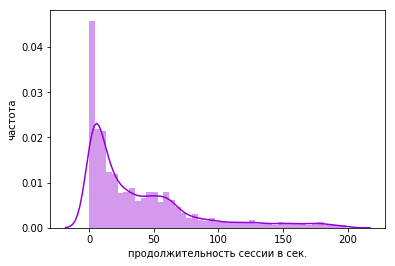

In [60]:
obj = new_features_10users.session_timespan
ax = sns.distplot(obj[obj<200], color='darkviolet')
ax.set_xlabel('продолжительность сессии в сек.')
ax.set_ylabel('частота')

### <font color='green'>2. Постройте гистограмму распределения числа уникальных сайтов в сессии (#unique_sites)</font>

Text(0,0.5,'частота')

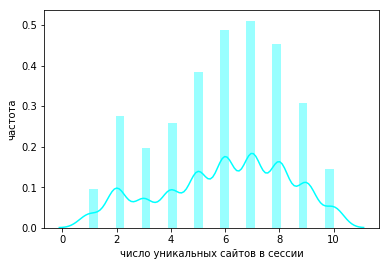

In [61]:
obj = new_features_10users['#unique_sites']
ax = sns.distplot(obj, color='aqua')
ax.set_xlabel('число уникальных сайтов в сессии')
ax.set_ylabel('частота')

### <font color='green'>3. Постройте гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности.</font>

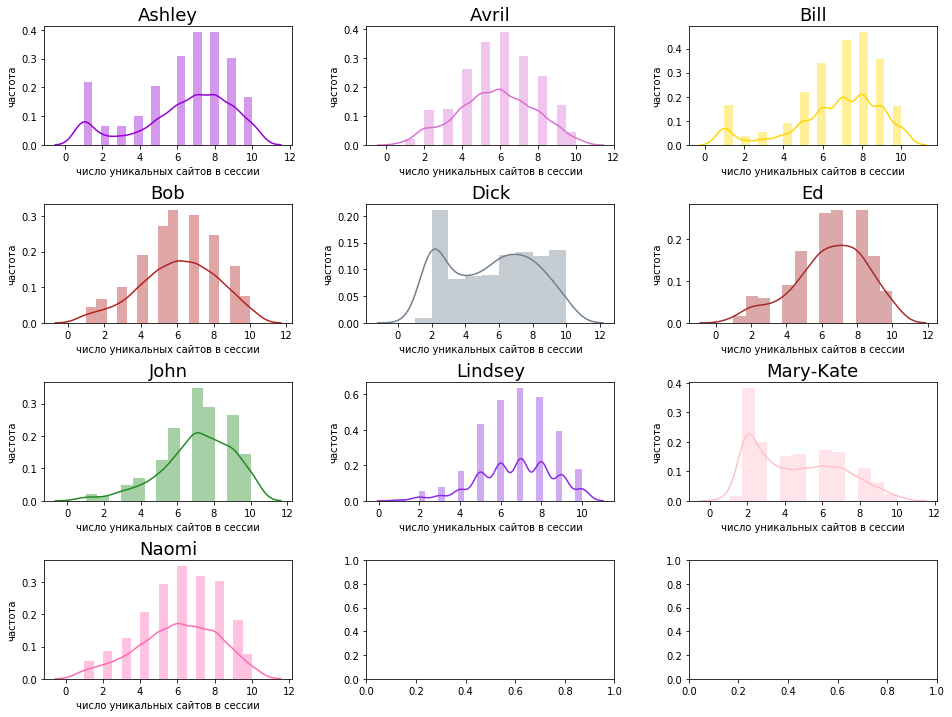

In [62]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    current_ax = axes[idx//3][idx%3]
    sns.distplot(pd.Series(sub_df['#unique_sites']), ax=current_ax, color=color_dic[user])
    current_ax.set_title(user, fontsize=18)
    current_ax.set_ylabel('частота')
    current_ax.set_xlabel('число уникальных сайтов в сессии')

### <font color='green'>4. Постройте гистограмму распределения часа начала сессии (start_hour)</font>

Text(0,0.5,'частота')

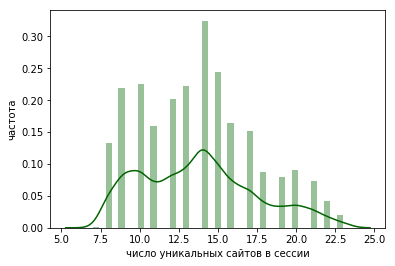

In [63]:
obj = new_features_10users['start_hour']
ax = sns.distplot(obj, color='darkgreen')
ax.set_xlabel('число уникальных сайтов в сессии')
ax.set_ylabel('частота')

### <font color='green'>5. Постройте гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности</font>

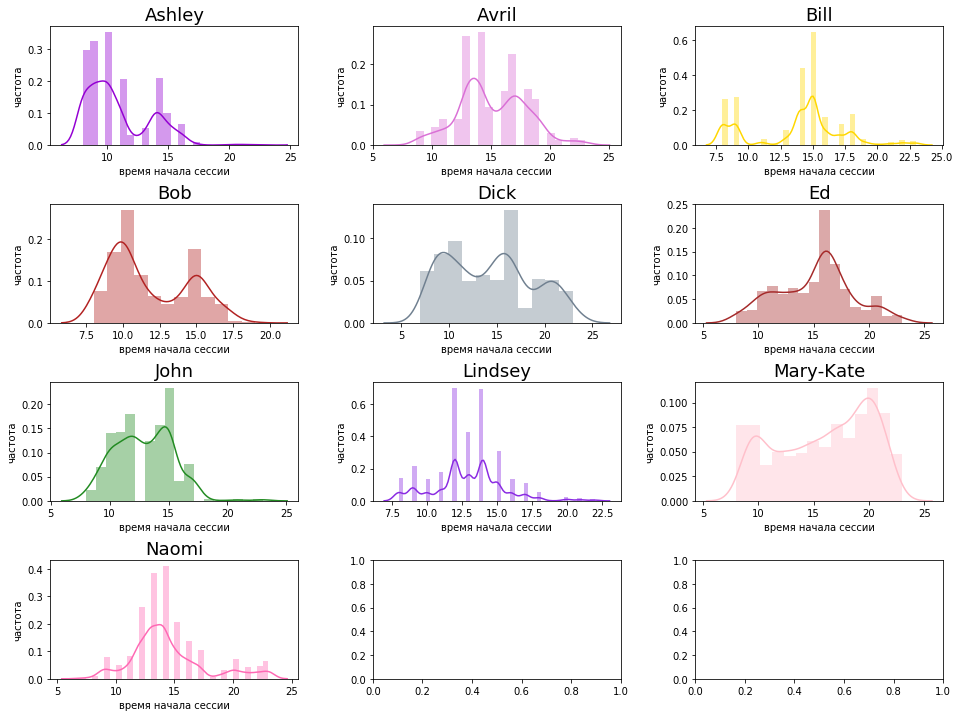

In [64]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    current_ax = axes[idx//3][idx%3]
    sns.distplot(pd.Series(sub_df['start_hour']), ax=current_ax, color=color_dic[user])
    current_ax.set_title(user, fontsize=18)
    current_ax.set_ylabel('частота')
    current_ax.set_xlabel('время начала сессии')

### <font color='green'>6. Постройте гистограмму распределения дня недели, в который началась сессия (day_of_week)</font>

In [65]:
x_values = [0,1,2,3,4,5,6,7]
substitute_x = ['Пн','Вт','Ср','Чт','Пт','Сб','Вс']

(0, 6)

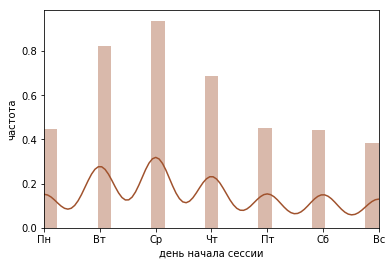

In [159]:
obj = new_features_10users['day_of_week']
ax = sns.distplot(obj, color='sienna')
ax.set_xlabel('день начала сессии')
ax.set_ylabel('частота')
ax.set_xticklabels(substitute_x)
ax.set_xlim(left=0, right=6)

### <font color='green'>7. Постройте гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности</font>

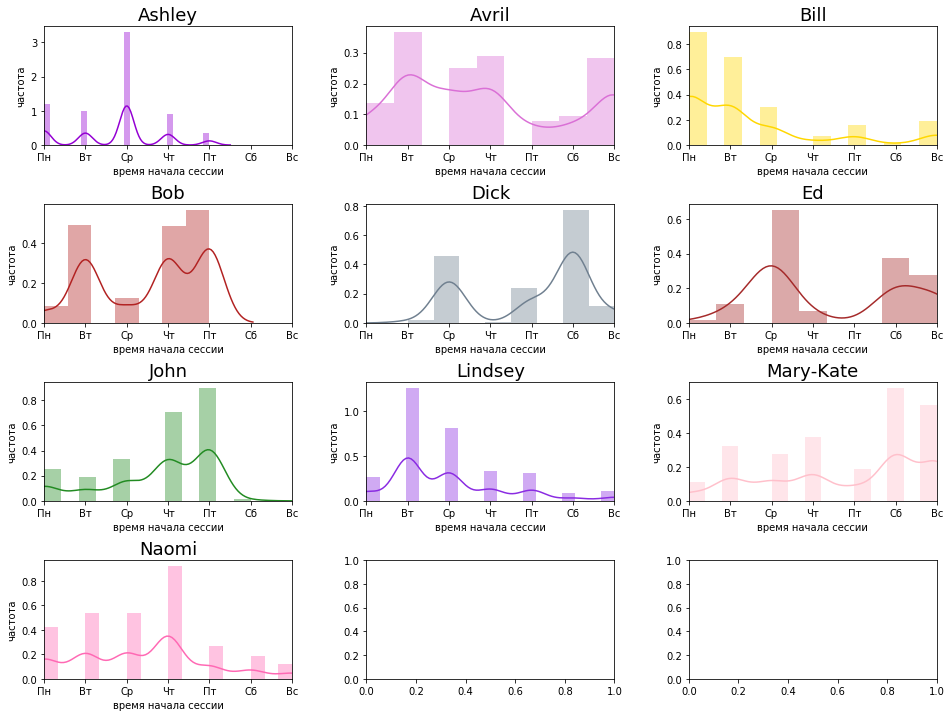

In [67]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    current_ax = axes[idx//3][idx%3]g
    sns.distplot(pd.Series(sub_df['day_of_week']), ax=current_ax, color=color_dic[user])
    current_ax.set_title(user, fontsize=18)
    current_ax.set_xticklabels(substitute_x)
    current_ax.set_ylabel('частота')
    current_ax.set_xlabel('время начала сессии')
    current_ax.set_xlim(left=0, right=6)    

### <font color='green'>8. Сделайте выводы про каждого пользователя по построенным графикам</font>

    Похоже, что у Dick и Mary-Kate есть некий основной сайт, с которого они периодически заглядывают на другие сайты, но неизменно возвращаясь к первоначальному, у остальных распределение похоже на нормальное, значит очевидных предпочтений нет.
    Большая часть пользователей предпочитает серфить в интернете утром около 10 и днем около 15, вечернее время, как ни странно популярно только у Mary-Kate. Что наводит на мысль о том, что для всех остальных участников кроме нее данные собирались с рабочего компьютера
    Следующие графики подтверждают мое предположение. У Ashley, Bob и Jhon сессий на выходных днях нет вообще. А для Dick и Ed распределение похоже на дискретное, что тоже может быть связанно с выходными, которые выпадают на другие дни

#### <font color='green'>Определите топ-10 самых посещаемых сайтов (top10_sites) и соответствующие кол-ва посещений (top10_freqs)</font>

In [68]:
with open(os.path.join(PATH_TO_DATA, 
                       'site_freq_10users.pkl'), 'rb') as site_freq_users_pkl:
    site_freq_10users = pickle.load(site_freq_users_pkl)

In [69]:
top10_freqs, top10_sites = [], []
for key, value in site_freq_10users.items():
    top10_freqs.append(value[1])
    top10_sites.append(key)
top10_freqs = top10_freqs[:10]
top10_sites = top10_sites[:10]
top10 = pd.DataFrame(columns=['sites','freq'])
top10.sites = top10_sites
top10.freq = top10_freqs

### <font color='green'>9. Нарисуйте seaborn barplot, показывающий частоты посещений топ-10 сайтов</font>

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

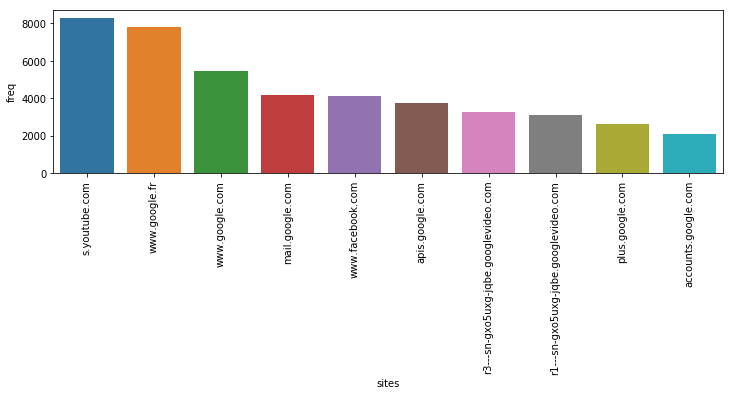

In [70]:
plt.figure(figsize=(12,3))
plt.rcParams.update({'font.size': 10})
sns.barplot(x='sites', y='freq', data=top10)
plt.xticks(rotation='vertical')

# Week_3_Part_3 Дальнейшее построение признаков
## -------------------------------------------------------------------------------------------

In [71]:
optional_features = ['day', 'month', 'year', 'hour_all',
                 'part_of_day', 'average_time(top_30)', 'count_top_30', 'count_facebook']

In [144]:
def feature_engineering(path_to_csv_files, site_freq_path, 
                        feature_names=None, session_length=10):
    window_size = 10
    # Все пути к файлам в указанной папке
    paths = sorted(glob(os.path.join(path_to_csv_files, '*.csv')))
    
    # Загрузим frequency 
    with open(site_freq_path, 'rb') as site_freq_users_pkl:
        frequency = pickle.load(site_freq_users_pkl)

     # Заполним features
    feat_list = list()
    
    for path in tqdm_notebook(paths):
        table = pd.read_csv(path)
        table['number'] = table.site.map(lambda x: frequency[x][0])
        numbers = list(table.number)
        
        # переведем столбец timestamp в соответствующий формат и в секунды
        timestamps = []
        original_timestamps = []
        for t in table.timestamp:
            ts = ciso8601.parse_datetime(t)
            # to get time in seconds:
            ts_sec = time.mktime(ts.timetuple())
            timestamps.append(int(ts_sec))
            original_timestamps.append(ts)
        
        # добавляем нули в неполные сессии
        for i in range(session_length-1):
            numbers.append(0)
            timestamps.append(timestamps[-1])
        
        for idx,num,timestamp in zip(range(len(numbers)), numbers, timestamps):
            if (idx%window_size==0)&(idx<=len(numbers)-session_length):
                # год, месяц и день начала сессии
                year = original_timestamps[idx].year
                month = original_timestamps[idx].month
                day = original_timestamps[idx].day
                # час начала сессии (с учетом года, месяца и дня)
                hour_all = timestamps[idx]//3600
                # время суток
                if hour_all%24<12:
                    part_of_day = 0  
                else:
                    part_of_day = 1  
                    
                # индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
                count_top, top, indices = 0, range(30), []
                for ind,i in enumerate(numbers[idx:idx+session_length]):
                    if i in top:
                        count_top += 1
                        if ind!=9:
                            indices.append(ind)
                        
                # среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
                time_diffs = (np.array(timestamps[idx+1:idx+session_length])\
                -np.array(timestamps[idx:idx+session_length-1])).tolist()
                temp = 0
                for i in indices:
                    temp += time_diffs[i]
                if temp!=0:
                    average_time = np.mean(temp)
                else:
                    average_time = None
                    
                # частота посещения Facebook
                count_facebook = 0
                if (5 in numbers[idx:idx+session_length]):
                    count_facebook = 1
                # -------------------------------------------------------
                feature = [day, month, year, hour_all, part_of_day, average_time,
                           count_top, count_facebook]
                feat_list.append(feature)
    
    features = pd.DataFrame(feat_list, columns=feature_names)
    
    return features

In [145]:
selected_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                    os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=optional_features, session_length=10)

In [ ]:
# selected_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
#                     os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
#                   feature_names=optional_features, session_length=10)

In [146]:
selected_features_10users.head()

,day,month,year,hour_all,part_of_day,average_time(top_30),count_top_30,count_facebook
0,15,11,2013,384581,0,1.0,2,0
1,15,11,2013,384581,0,NaN,0,0
2,15,11,2013,384581,0,14.0,2,1
3,15,11,2013,384581,0,NaN,0,0
4,15,11,2013,384581,0,1.0,1,1


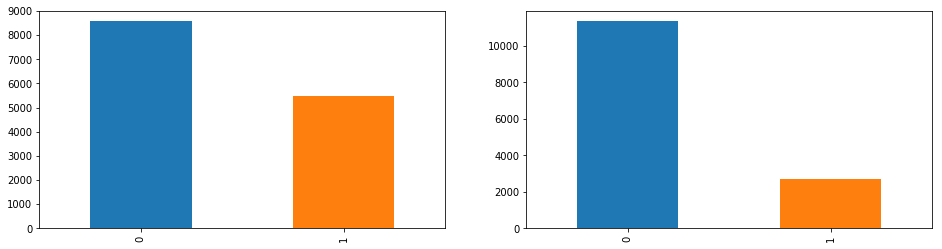

In [148]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
selected_features_10users.part_of_day.value_counts().plot.bar(ax=axes[0])
selected_features_10users.count_facebook.value_counts().plot.bar(ax=axes[1])

<font color='green'>Деление по признаку a.m./p.m. ,на мой взгляд,дает бесполезные результаты, ночью и утром больше активности, чем днем. Хотя очевидно, что большая ее часть приходится на утренние часы.
На втором графике видно, что около четверти сессий включают в себя facebook</font>

In [86]:
average_time = selected_features_10users['average_time(top_30)']
average_time.drop(index=average_time[average_time.isna()].index, inplace=True)

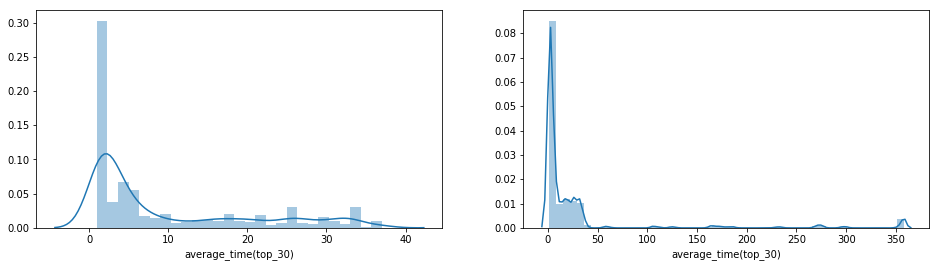

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(average_time[average_time<50], ax=axes[0])
sns.distplot(average_time, ax=axes[1])

<font color='green'>В основном пользователи проводят на сайте до 50 сек</font>

(0, 10)

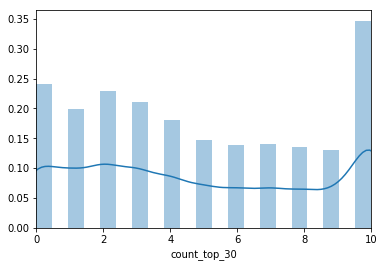

In [125]:
sns.distplot(selected_features_10users.count_top_30)
plt.xlim(left=0, right=10)

<font color='green'>Чаще всего все 10 сайтов из top_10 участвуют в сессии</font>